# SISO + Noise

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## 0. System model

Consider the following single-degree-of-freedom "damped oscillator".

parameter | value
----------|-------
m  | mass
k  | stiffness
c  | damping coefficient

![sdof](../../figures/sdof.png)

The oscillator is subject to the following forcing function:

$f(t) = e^{-at}\sin{bt}$

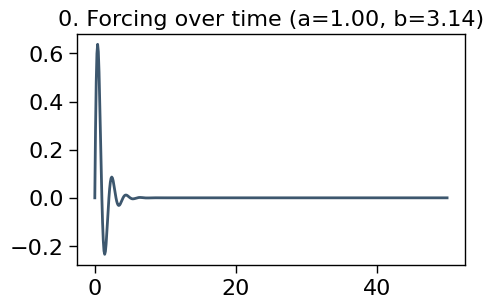

In [2]:
a = 1
b = np.pi
nt = 500
dt = 0.1
time = np.arange(0,nt*dt,dt)
force = np.exp(-a*time)*np.sin(b*time)
_, ax = plt.subplots(figsize=(5,3))
ax.plot(time, force)
ax.set_title(f"0. Forcing over time ({a=:.2f}, {b=:.2f})");

The differential equation governing the motion of the oscillator is

$m\ddot{u} + c\dot{u} + ku = f(t), \quad{} u(0)=u_{0}, \quad{} \dot{u}(0)=\dot{u}_{0}$.

Assuming $c^{2}-4mk < 0$, and $b \neq \frac{\sqrt{4mk-c^{2}}}{2m}$, the oscillator's response is

$$u(t) = C_{1}e^{\alpha t}\cos{\beta t} + C_{2}e^{\alpha t}\sin{\beta t} + C_{3}e^{-at}\cos{bt} + C_{4}e^{-at}\sin{bt}$$

$$\alpha = -\frac{c}{2m}, \quad{} \beta = \frac{\sqrt{4mk-c^{2}}}{2m}$$

$$
C_{3} = \frac{ -(2mab+cb) }{ (ma^{2}-mb^{2}-ca+k)^{2} - (2mab+cb)(2mab-cb) }
$$
$$
C_{4} = \frac{ (ma^{2}-mb^{2}-ca+k) }{ (ma^{2}-mb^{2}-ca+k)^{2} - (2mab+cb)(2mab-cb) }
$$
$$
C_{1} = u_{0} - C_{3}
$$
$$
C_{2} = \frac{ 2m }{ \sqrt{4mk-c^{2}} }\left( \frac{c}{2m}C_{1} + aC_{3} - bC_{4} + \dot{u}_{0} \right)
$$


The response of the oscillator is plotted alongside the input forcing below.

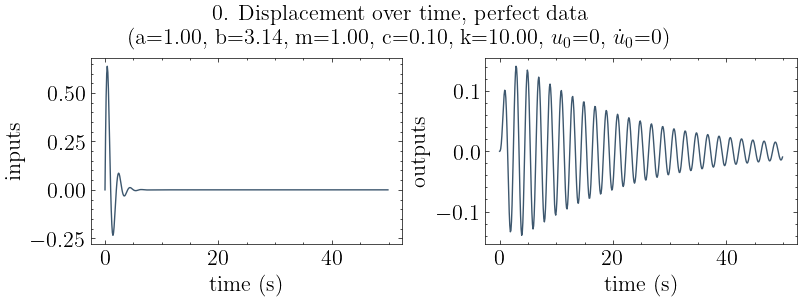

In [3]:
m = 1
c = 0.1
k = 10
a = 1
b = np.pi
u0 = 0
udot0 = 0
force = np.exp(-a*time)*np.sin(b*time)
C3 = -(2*m*a*b+c*b) / ( (m*a**2-m*b**2-c*a+k)**2-(2*m*a*b+c*b)*(2*m*a*b-c*b) )
C4 = -(m*a**2-m*b**2-c*a+k) / ( (m*a**2-m*b**2-c*a+k)**2-(2*m*a*b+c*b)*(2*m*a*b-c*b) )
C1 = u0-C3
C2 = 2*m*(c*C1/(2*m)+a*C3-b*C4+udot0)/np.sqrt(4*m*k-c**2)
alpha = -c/(2*m)
beta = np.sqrt(4*m*k-c**2)/(2*m)
response = C1*np.exp(alpha*time)*np.cos(beta*time) + C2*np.exp(alpha*time)*np.sin(beta*time) + C3*np.exp(-a*time)*np.cos(b*time) + C4*np.exp(-a*time)*np.sin(b*time)
title = "0. Displacement over time, perfect data\n" \
          rf"({a=:.2f}, {b=:.2f}, {m=:.2f}, {c=:.2f}, {k=:.2f}, $u_{0}$={u0}, $\dot u_{0}$={udot0})"
from mdof.utilities.printing import plot_io
plot_io(inputs=force, outputs=response, t=time, title=title)

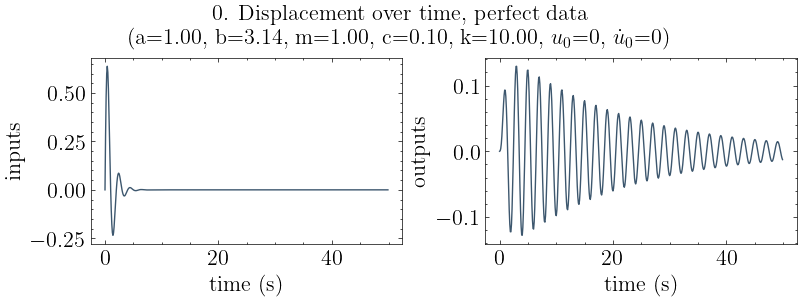

In [4]:
# We can also simulate the response, if we don't know it in closed-form.
# This is called numerical integration, which is a way to solve initial value problems for ODEs.
import sdof
simulated_response,_,_ = sdof.integrate(force,dt,k,c,m)
plot_io(inputs=force, outputs=simulated_response, t=time, title=title)

## 1. Perform System Identification - perfect input and output

In [5]:
# Generate a state space realization of the system
import mdof
from mdof.utilities.printing import print_modes
A,B,C,D = mdof.system(inputs=force, outputs=response, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = mdof.modal.system_modes((A,B,C,D),dt,outlook=190)
# Actual period
Tn = 2*np.pi*np.sqrt(m/k)
zeta = c/(2*np.sqrt(m*k))
print("\nACTUAL VALUES")
print(f"Actual period: {np.round(Tn,3)}s; Actual damping: {np.round(zeta,3)}")
print("\nPREDICTED/IDENTIFIED VALUES FROM DATA")
print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 200/201 [00:00<00:00, 89583.60it/s]


ACTUAL VALUES
Actual period: 1.987s; Actual damping: 0.016

PREDICTED/IDENTIFIED VALUES FROM DATA
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC     T % error    ζ % error
      1.987      0.01581    1.0        1.0        1.0          6.705e-14    -2.458e-12
Mean Period(s): 1.9869176531592216
Standard Dev(s): 0.0


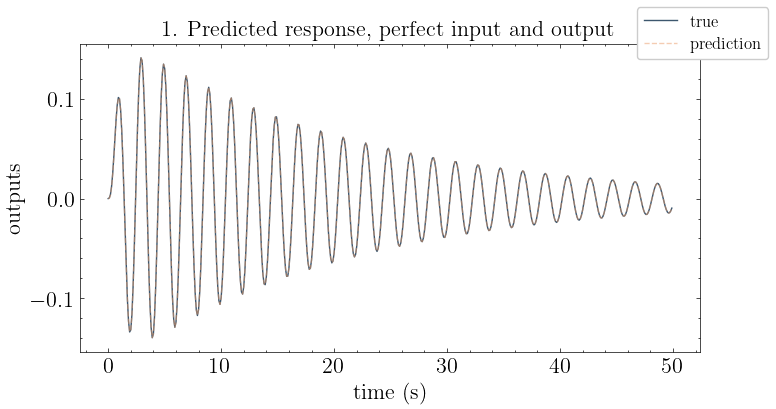

In [6]:
# Reproduce the response with the state space model
from mdof.utilities.testing import forced_response
from mdof.utilities.printing import plot_pred
from control import ss
y_mdof = forced_response(ss(A,B,C,D,dt), T=time, U=force, squeeze=False, return_x=False).outputs
plot_pred(ytrue=response, models=y_mdof, t=time, title="1. Predicted response, perfect input and output")

## 2. Perform System Identification - with input measurement noise

What if the measurement of the input is noisy? i.e., the input force is recorded with some inaccuracies.

Add noise with standard deviation of $\sigma=0.1(\max{f(t)})$ and mean of $\mu=0$ to the input, `force`, using [`np.random.normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html).

Use the response, `response`, with a noisy input, `noisy_force`, to perform system identification.

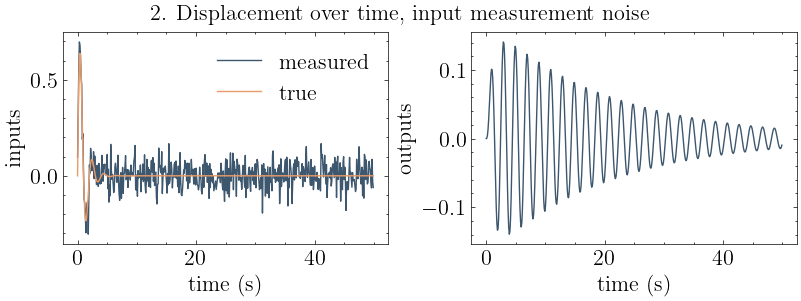

In [7]:
# Add noise to force
noisy_force = force + np.random.normal(0,0.1*np.max(force),len(force))
title = "2. Displacement over time, input measurement noise"
plot_io(inputs=np.array([noisy_force, force]), outputs=response, t=time, title=title)
plt.gcf().axes[0].legend(["measured", "true"]);

In [8]:
# Generate a state space realization of the system
A,B,C,D = mdof.system(inputs=noisy_force, outputs=response, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = mdof.modal.system_modes((A,B,C,D),dt,outlook=190)
print("\nACTUAL VALUES")
print(f"Actual period: {np.round(Tn,3)}s; Actual damping: {np.round(zeta,3)}")
print("\nPREDICTED/IDENTIFIED VALUES FROM DATA")
print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 200/201 [00:00<00:00, 48876.12it/s]


ACTUAL VALUES
Actual period: 1.987s; Actual damping: 0.016

PREDICTED/IDENTIFIED VALUES FROM DATA
No valid identified modes.


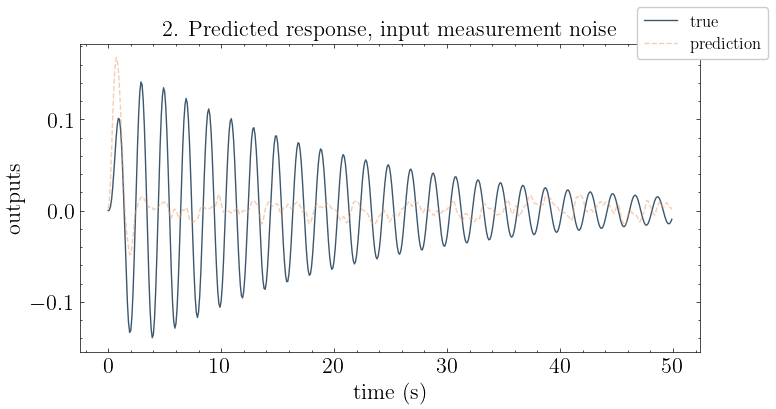

In [9]:
# Reproduce the response with the state space model
y_mdof = forced_response(ss(A,B,C,D,dt), T=time, U=noisy_force, squeeze=False, return_x=False).outputs
plot_pred(ytrue=response, models=y_mdof, t=time, title="2. Predicted response, input measurement noise")

## 3. Perform System Identification - output measurement noise

What if the output measurement is noisy? i.e., the output is recorded with some inaccuracies.

Add noise with standard deviation of $\sigma=0.1(\max{u(t)})$ and mean of $\mu=0$ to the output, `response`, using [`np.random.normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html).

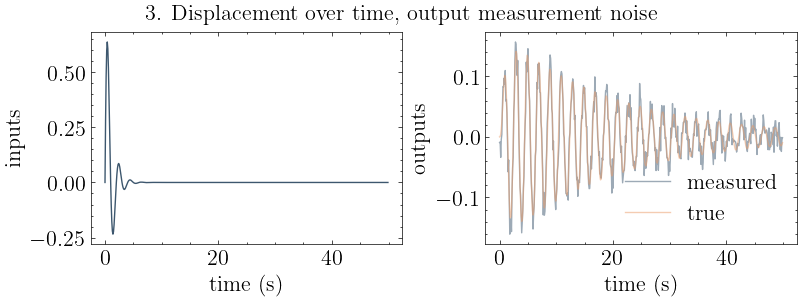

In [10]:
# Add noise to response
noisy_response = response + np.random.normal(0,0.1*np.max(response),len(response)) 
title = "3. Displacement over time, output measurement noise"
plot_io(inputs=force, outputs=np.array([noisy_response, response]), t=time, title=title)
plt.gcf().axes[1].legend(["measured", "true"]);

In [11]:
# Generate a state space realization of the system
A,B,C,D = mdof.system(inputs=force, outputs=noisy_response, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = mdof.modal.system_modes((A,B,C,D),dt,outlook=190)
print("\nACTUAL VALUES")
print(f"Actual period: {np.round(Tn,3)}s; Actual damping: {np.round(zeta,3)}")
print("\nPREDICTED/IDENTIFIED VALUES FROM DATA")
print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 200/201 [00:00<00:00, 125747.38it/s]


ACTUAL VALUES
Actual period: 1.987s; Actual damping: 0.016

PREDICTED/IDENTIFIED VALUES FROM DATA
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC     T % error    ζ % error
      1.986      0.01604    1.0        1.0        1.0          -0.0254      1.425    
Mean Period(s): 1.9864129367991532
Standard Dev(s): 0.0


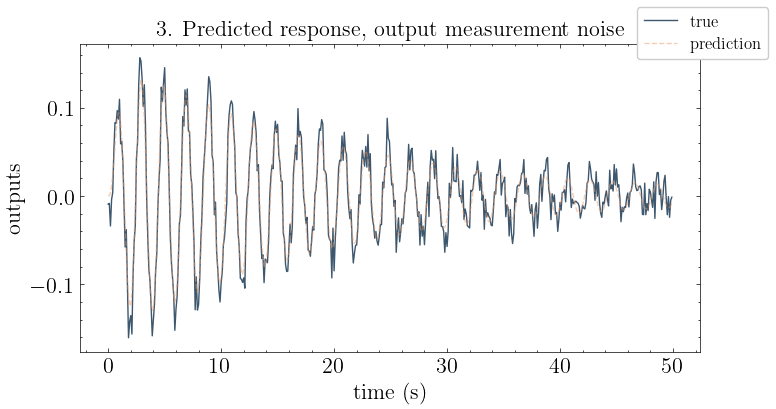

In [12]:
# Reproduce the response with the state space model
y_mdof = forced_response(ss(A,B,C,D,dt), T=time, U=force, squeeze=False, return_x=False).outputs
plot_pred(ytrue=noisy_response, models=y_mdof, t=time, title="3. Predicted response, output measurement noise")

## 4. Perform System Identification - with input and output measurement noise

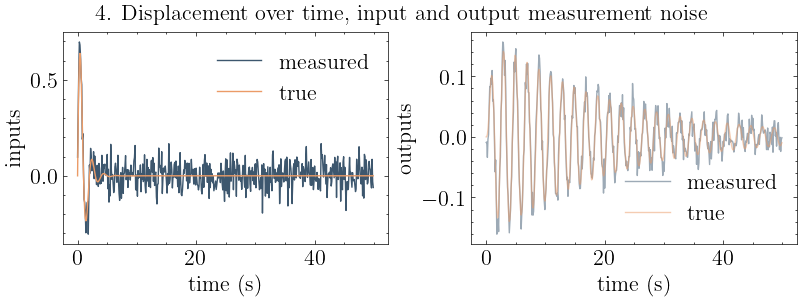

In [13]:
# Add measurement noise to the response to a disturbed input.
title = "4. Displacement over time, input and output measurement noise"
plot_io(inputs=np.array([noisy_force,force]), outputs=np.array([noisy_response,response]), t=time, title=title)
plt.gcf().axes[0].legend(["measured", "true"])
plt.gcf().axes[1].legend(["measured", "true"]);

In [14]:
# Generate a state space realization of the system
A,B,C,D = mdof.system(inputs=noisy_force, outputs=noisy_response, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = mdof.modal.system_modes((A,B,C,D),dt,outlook=190)
print("\nACTUAL VALUES")
print(f"Actual period: {np.round(Tn,3)}s; Actual damping: {np.round(zeta,3)}")
print("\nPREDICTED/IDENTIFIED VALUES FROM DATA")
print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 200/201 [00:00<00:00, 87390.44it/s]


ACTUAL VALUES
Actual period: 1.987s; Actual damping: 0.016

PREDICTED/IDENTIFIED VALUES FROM DATA
No valid identified modes.


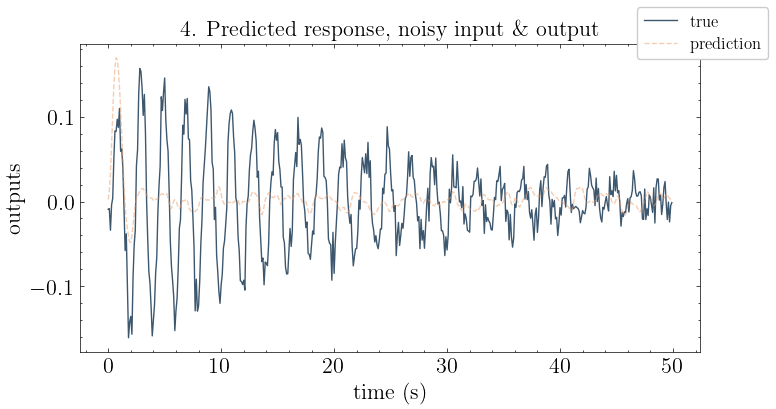

In [15]:
# Reproduce the response with the state space model
y_mdof = forced_response(ss(A,B,C,D,dt), T=time, U=noisy_force, squeeze=False, return_x=False).outputs
plot_pred(ytrue=noisy_response, models=y_mdof, t=time, title=r"4. Predicted response, noisy input \& output");

## 5. Perform System Identification - with an impure input

What if the input has some disturbances, not just in its measurements?  These disturbances will affect the output as well.

Assume the input is affected by some random disturbances, but that we measure those disturbances perfectly. Also assume the output is measured perfectly.

Add random disturbance to the original input, `force`, to get `disturbed_force`.  Then, simulate its output using `sdof.integrate` and save the response as `response_from_disturbed`.  Perform system identification on this input-output pair.

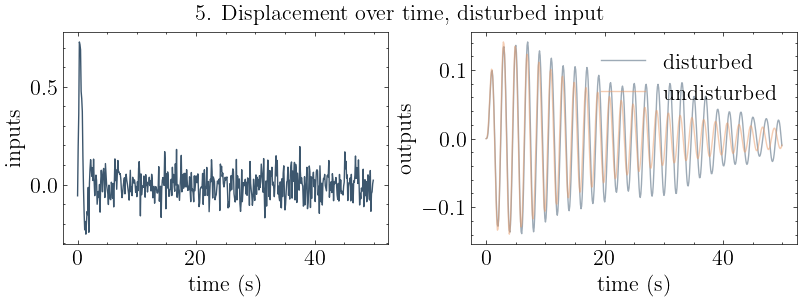

In [16]:
# Disturb the force
disturbed_force = force + np.random.normal(0,0.1*np.max(force),len(force))
response_from_disturbed,_,_ = sdof.integrate(disturbed_force,dt,k,c,m)
response_from_disturbed = response_from_disturbed*np.max(response)/np.max(response_from_disturbed)
title = "5. Displacement over time, disturbed input"
plot_io(inputs=disturbed_force, outputs=np.array([response_from_disturbed,response]), t=time, title=title)
plt.gcf().axes[1].legend(["disturbed", "undisturbed"]);

In [17]:
# Generate a state space realization of the system
A,B,C,D = mdof.system(inputs=disturbed_force, outputs=response_from_disturbed, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = mdof.modal.system_modes((A,B,C,D),dt,outlook=190)
print("\nACTUAL VALUES")
print(f"Actual period: {np.round(Tn,3)}s; Actual damping: {np.round(zeta,3)}")
print("\nPREDICTED/IDENTIFIED VALUES FROM DATA")
print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 200/201 [00:00<00:00, 80558.99it/s]


ACTUAL VALUES
Actual period: 1.987s; Actual damping: 0.016

PREDICTED/IDENTIFIED VALUES FROM DATA
No valid identified modes.


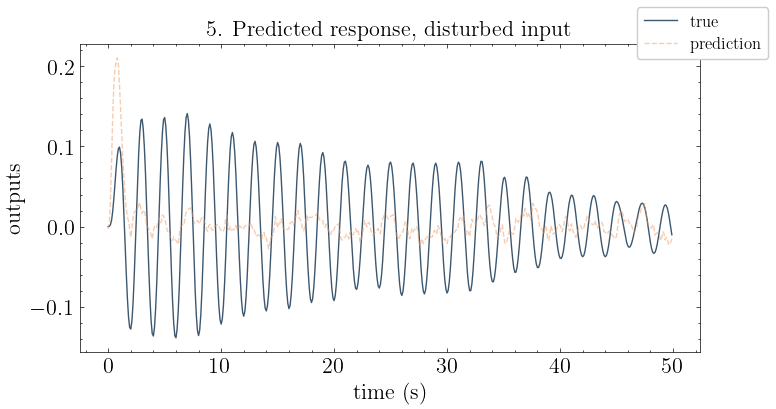

In [18]:
# Reproduce the response with the state space model
y_mdof = forced_response(ss(A,B,C,D,dt), T=time, U=disturbed_force, squeeze=False, return_x=False).outputs
plot_pred(ytrue=response_from_disturbed, models=y_mdof, t=time, title=r"5. Predicted response, disturbed input");